# py2cytoscape 0.6.0 New Features

By Keiichiro Ono (kono ucsd edu)

Updated on 7/14/2016

## New in 0.6.0
* Session Saving and loading API
* Bug fixes
* Preset layout utility method

In [1]:
!python --version

Python 3.5.2 :: Anaconda 4.1.1 (x86_64)


In [21]:
# Boilerplate: Import required packages
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.util_network import NetworkUtil as util
import py2cytoscape.cytoscapejs as renderer
from IPython.display import Image
import networkx as nx
from networkx.drawing import nx_pydot as pyd
import igraph as ig

## Create client and clean up workspace

In [22]:
# Create Client
cy = CyRestClient()

# Clear current session
cy.session.delete()

## Creating networks with NetworkX and igraph

In [23]:
# Create with NetworkX (Scale-Free graph w/100 nodes)
g = nx.powerlaw_cluster_graph(50,4, 0.5)

# Calculate some graph statistics
deg = nx.degree(g)
btw = nx.betweenness_centrality(g)
nx.set_node_attributes(g, 'degree', deg)
nx.set_node_attributes(g, 'betweenness', btw)

# Create with igraph (Tree w/500 nodes)
g2 = ig.Graph.Tree(400, 5)

## Use 3rd party layout algorithms which does not exists in Cytoscape

In [24]:
# Graphviz Layout
n_layout = pyd.graphviz_layout(g, prog='dot')

# Reingold-Tilford tree layout with a polar coordinate post-transformation
i_layout = g2.layout("rt_circular")
i_layout.scale(200)

In [26]:
g_cy = cy.network.create_from_networkx(g)
nodes = g_cy.get_nodes()
idmap = util.name2suid(g_cy)
locations =[]

for k in n_layout.keys():
    v = n_layout[k]
    locations.append([int(idmap[k]), v[0] , v[1]])

cy.layout.apply_from_presets(g_cy, positions=locations)
cy.layout.bundle_edge(g_cy)
my_style = cy.style.create('Curved')
cy.style.apply(style=my_style, network=g_cy)

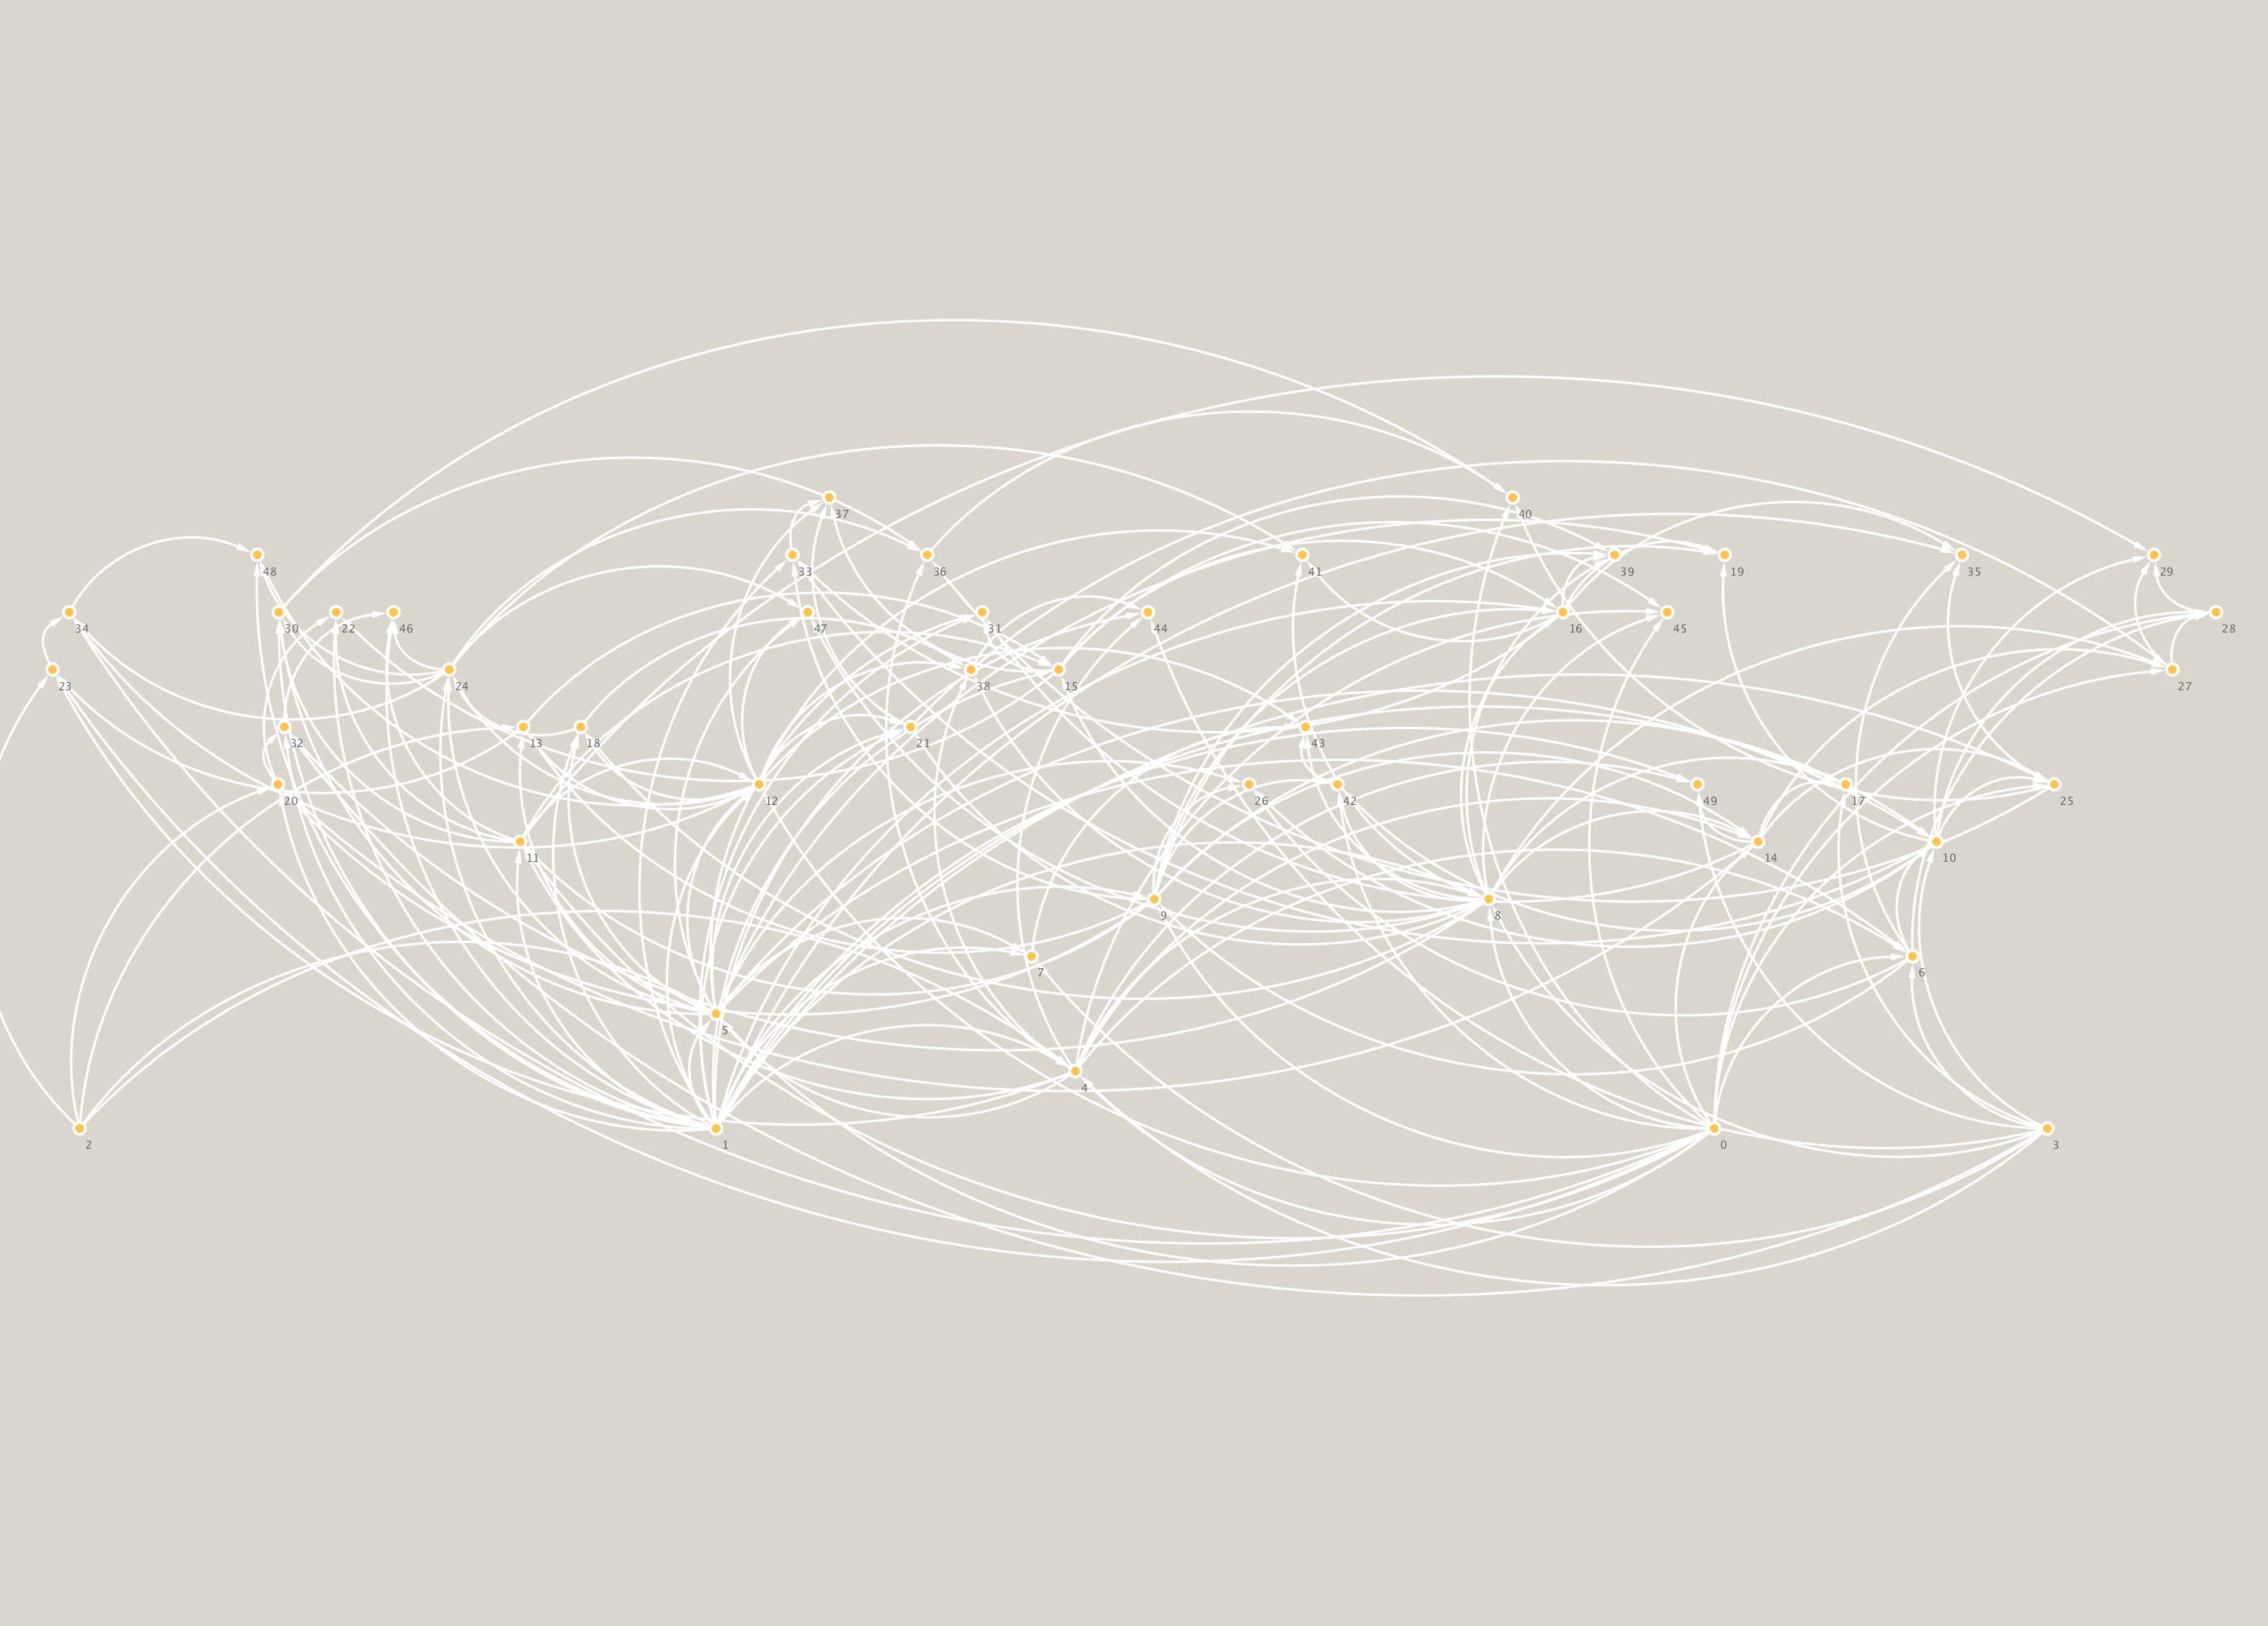

In [27]:
Image(g_cy.get_png(height=2000))

In [28]:
style_for_widget = cy.style.get(my_style.get_name(), data_format='cytoscapejs')
renderer.render(g_cy.get_first_view(), style=style_for_widget['style'], background='radial-gradient(#FFD39B 30%, #FFFFFF 105%)')

In [18]:
g2_cy = cy.network.create_from_igraph(g2)
nodes = g2_cy.get_nodes()
idmap = util.name2suid(g2_cy)
locations =[]
for i, l in enumerate(i_layout):
    locations.append([int(idmap[i]), l[0] , l[1] ])

cy.layout.apply_from_presets(g2_cy, positions=locations)
style_3 = cy.style.create('Sample3')
cy.style.apply(style=style_3, network=g2_cy)
cy.layout.bundle_edge(g2_cy)

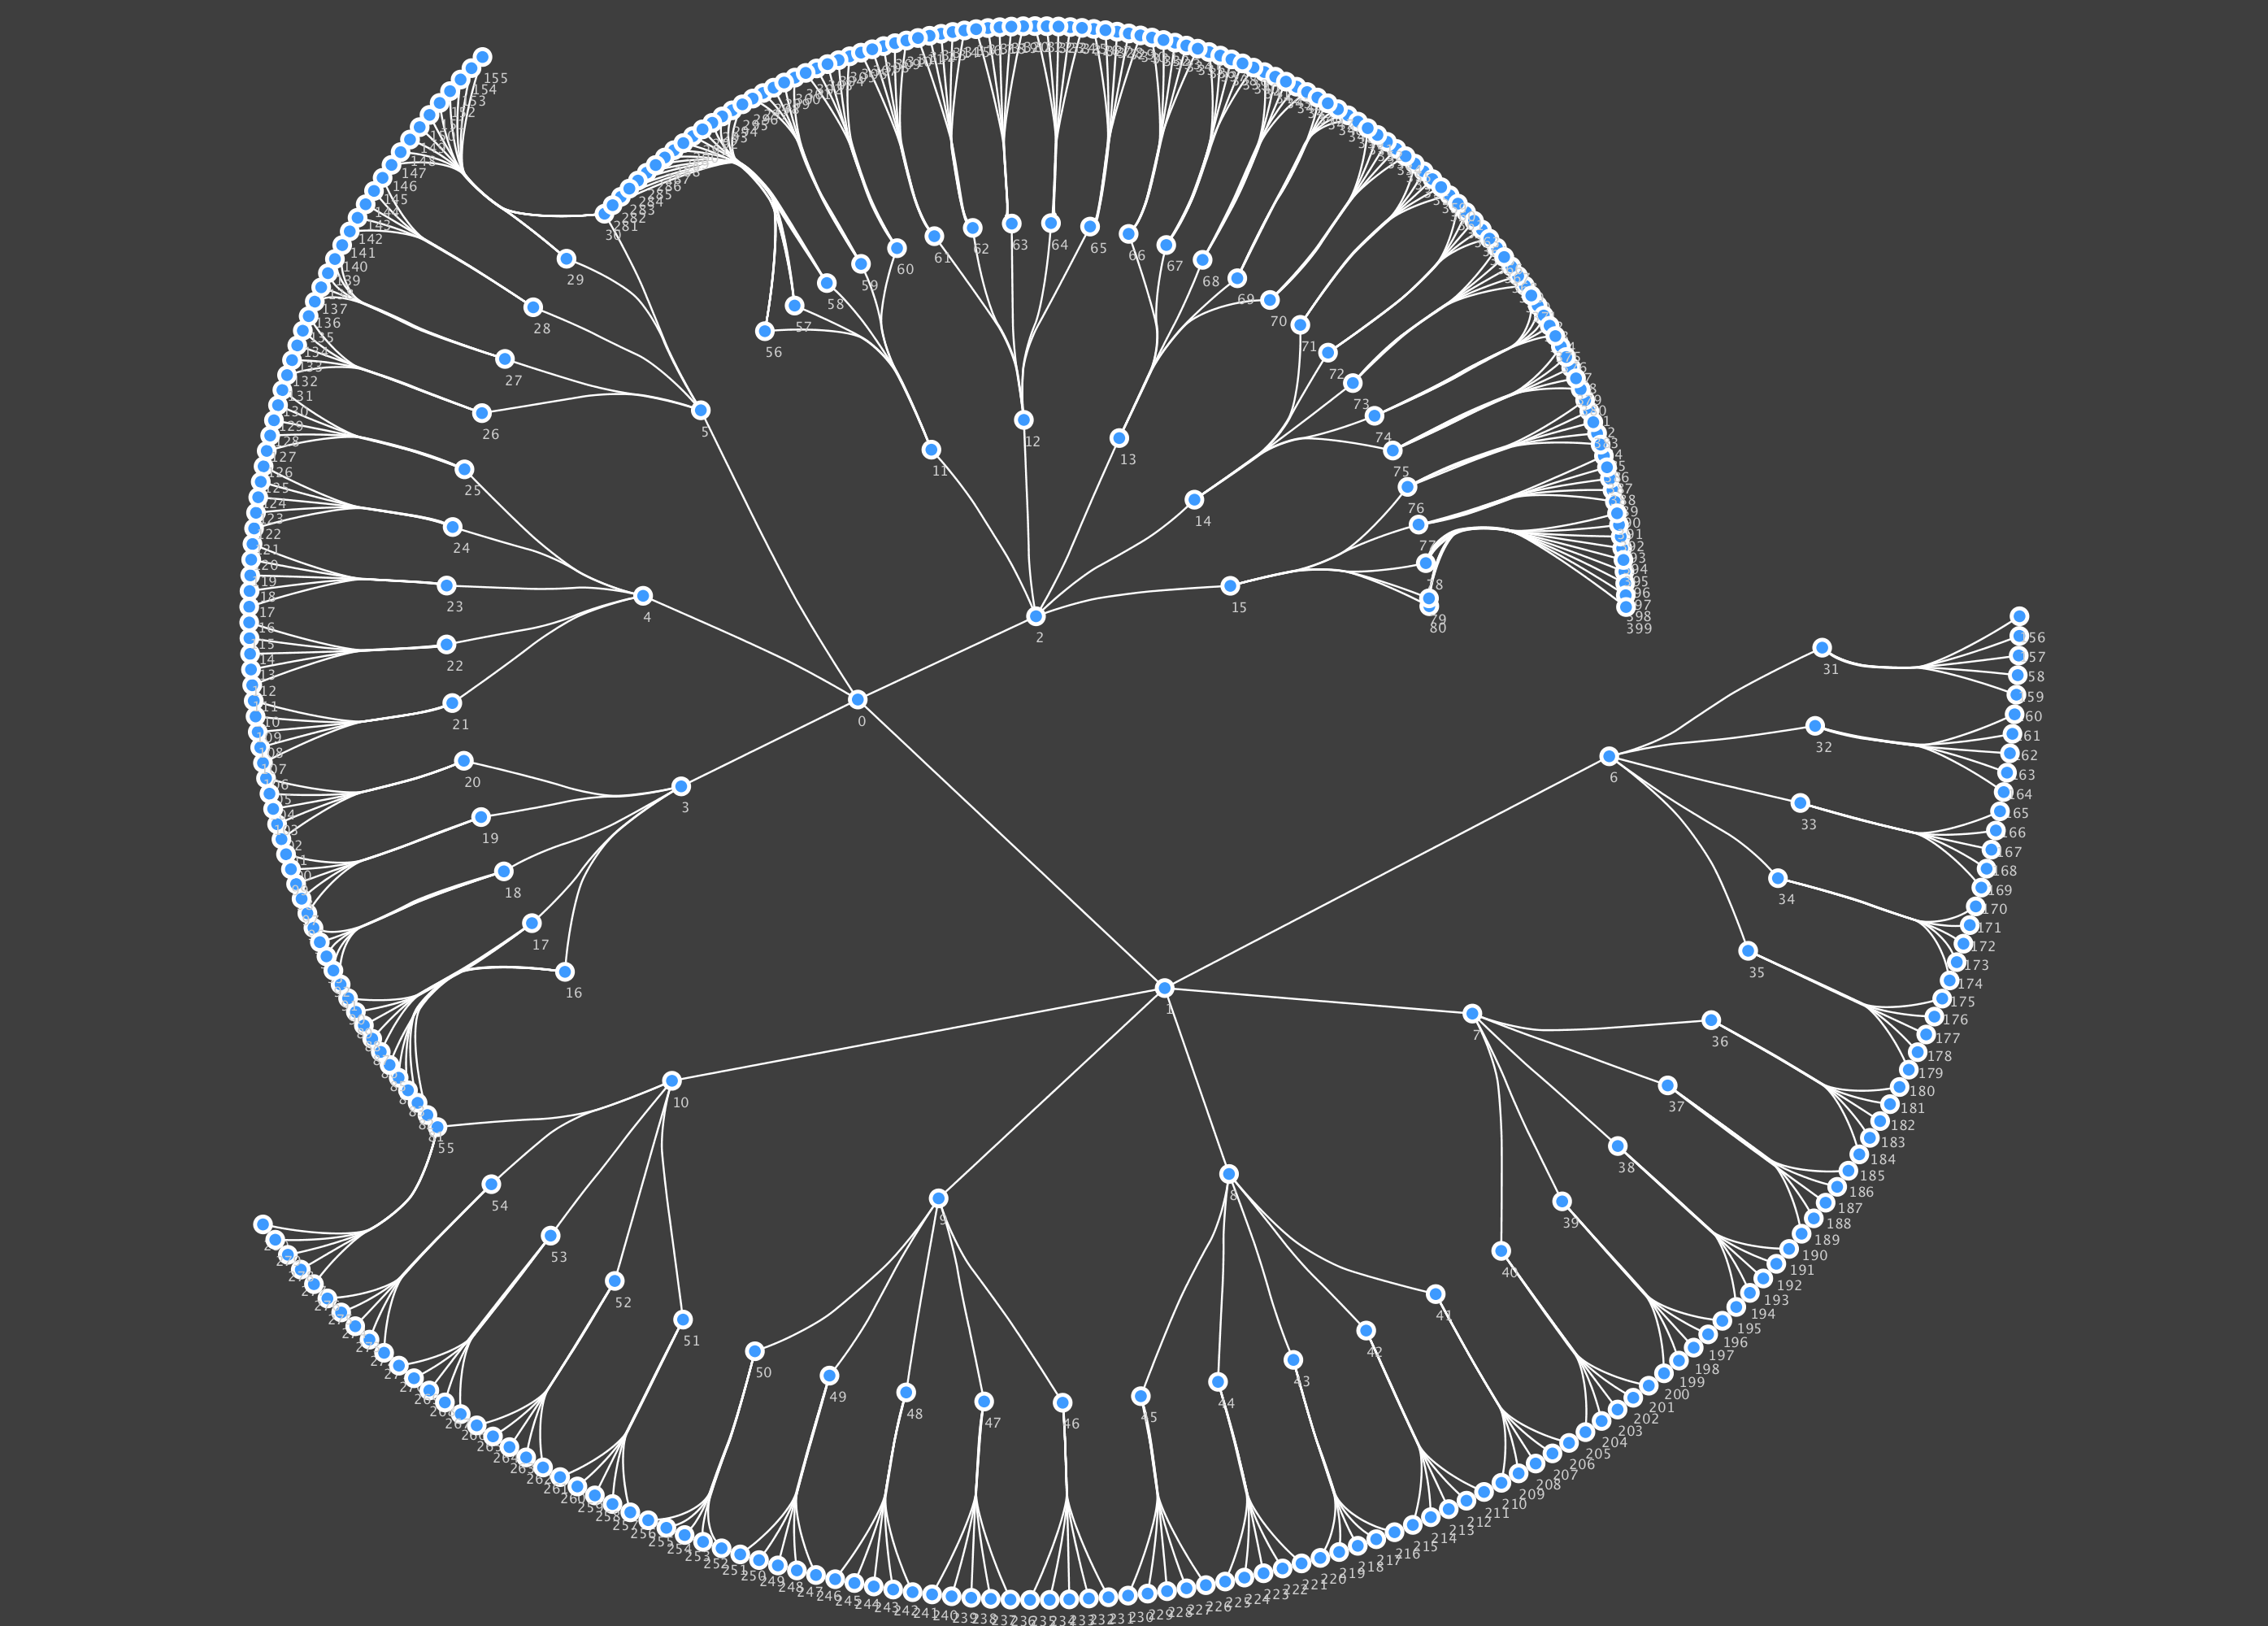

In [19]:
Image(g2_cy.get_png(height=2000))

In [20]:

renderer.render(g2_cy.get_first_view(), background='radial-gradient(#FFFFFF 10%, #999999 105%)')

In [ ]:
# Save the session
cy.session.save(file_name='/Users/kono/test34.cys')

In [ ]:
cy.session.open(file_name='/Users/kono/test34.cys')